<a href="https://colab.research.google.com/github/diegocp01/diegocp01-github.io/blob/main/GRADIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRADIO guide

[Step by step guide](https://experienced-soldier-fb5.notion.site/Introduction-to-Gradio-616592a3338944909de32db061ec4bea?pvs=4)

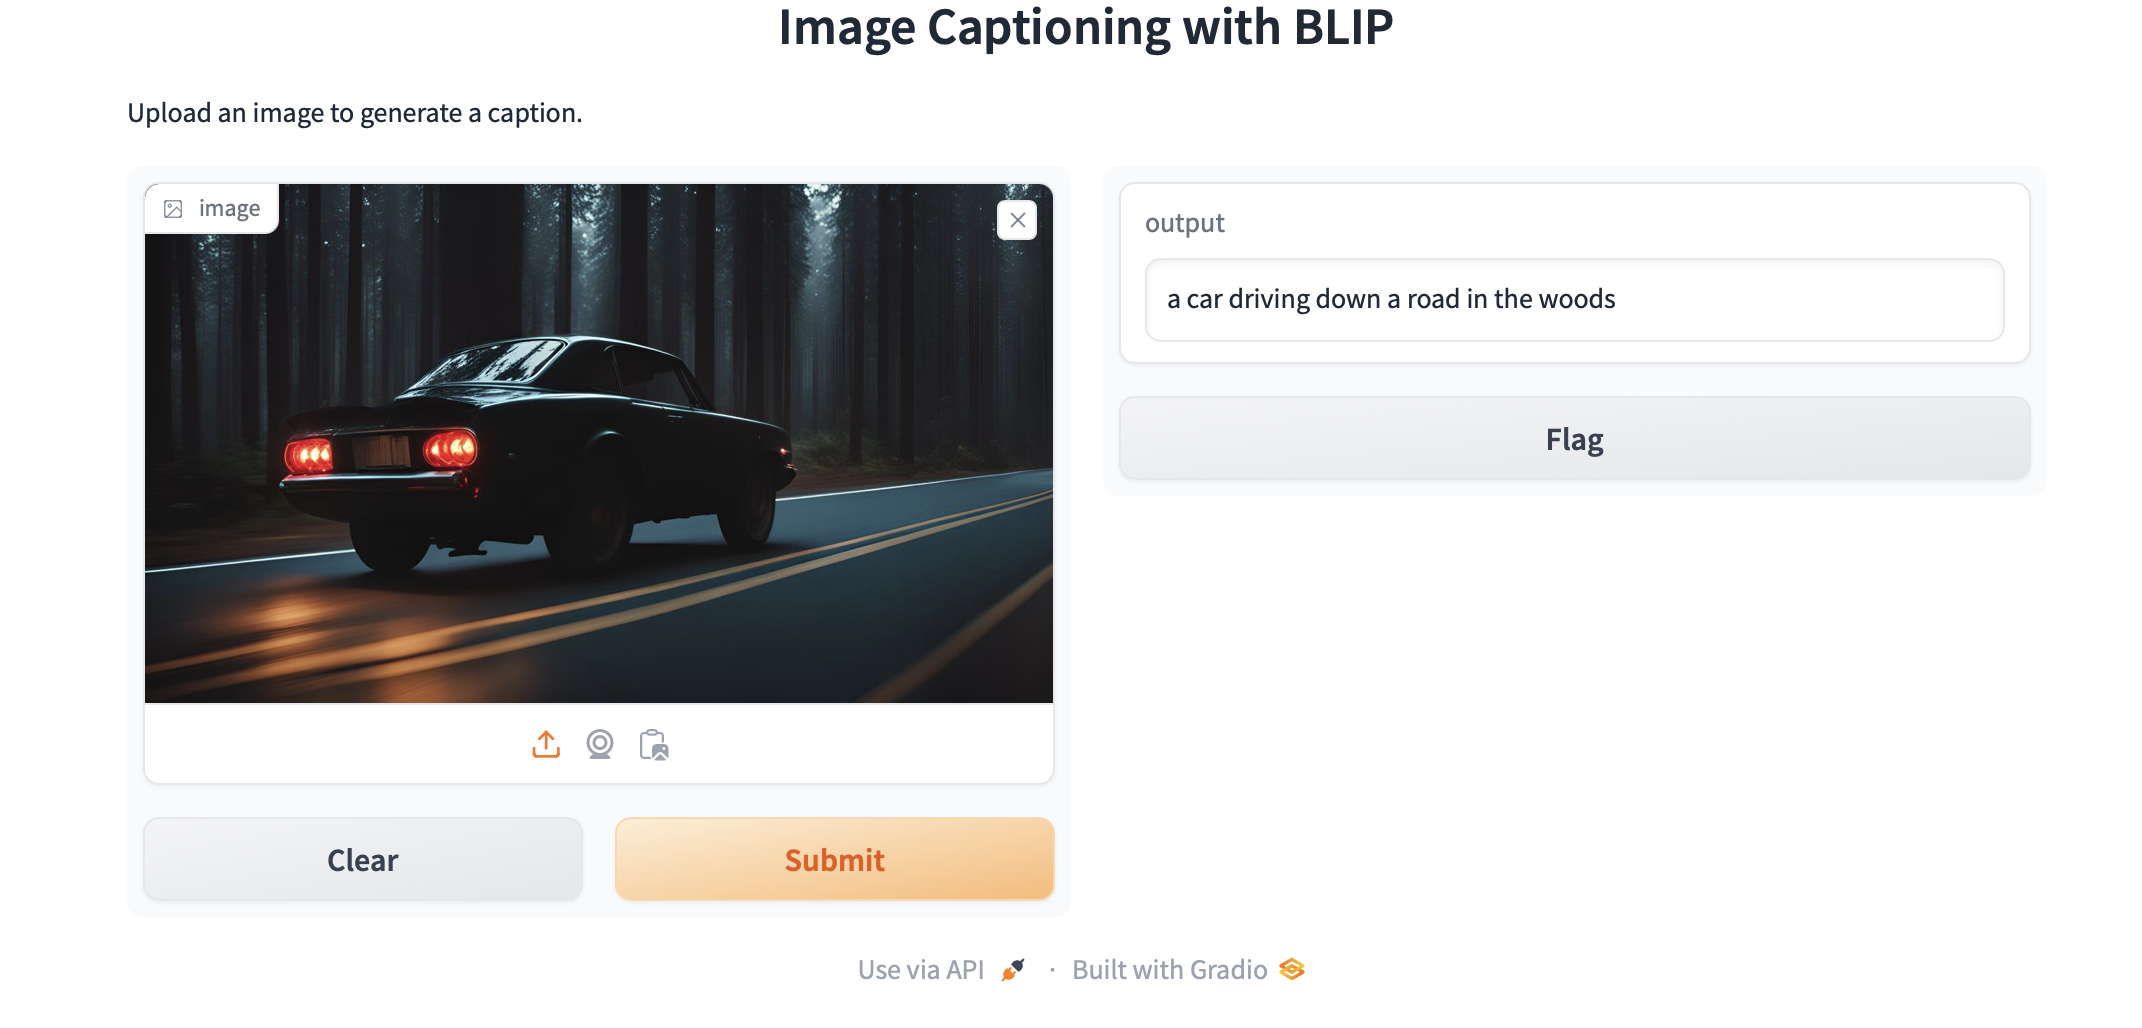

# Overview

## Install & import

In [15]:
# Installs
!pip install gradio

In [16]:
import gradio as gr

## Set up

In [17]:
# Function for the UI
def greet(name, intensity):
  return "Hello, " + name + "!" * int(intensity)

# Set up of the UI
demo = gr.Interface(
  fn=greet,
  inputs=["text", "slider"],
  outputs=["text"],
)

# Gradio Launch
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://04820344f665eddb24.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


### Experiments

#### Sentiment Analyzer: Feel the Vibe!

In [18]:
from textblob import TextBlob

# Function to analyze sentiment
def analyze_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity

    # Determine sentiment category
    if polarity > 0:
        sentiment = "Positive 😀"
    elif polarity < 0:
        sentiment = "Negative 😟"
    else:
        sentiment = "Neutral 😐"

    # Return polarity score and sentiment category
    return polarity, sentiment

# Create the Gradio interface
demo2 = gr.Interface(
    fn=analyze_sentiment,
    inputs="text",
    outputs=["number", "text"],
    title="Sentiment Analysis Tool",
    description="Enter a piece of text to analyze its sentiment. The tool will return a polarity score (-1 to 1) and a sentiment category.",
    examples=[
        "I love sunny days!",
        "This is the worst experience ever.",
        "I'm feeling okay today."
    ]
)

# Launch the interface
demo2.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://16d09405bc6c6b4755.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


---

# Image captioning model UI - BLIP

Let’s create a simple interface for an image captioning model. The BLIP (Bootstrapped Language Image Pretraining) model can generate captions for images. Here's how you can create a Gradio interface for the BLIP model.

In [19]:
# Install
!pip install transformers

In [20]:
# Imports
import gradio as gr
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image

In [21]:


# Set up BLIP
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

def generate_caption(image):
    # Now directly using the PIL Image object
    inputs = processor(images=image, return_tensors="pt")
    outputs = model.generate(**inputs)
    caption = processor.decode(outputs[0], skip_special_tokens=True)
    return caption

def caption_image(image):
    """
    Takes a PIL Image input and returns a caption.
    """
    try:
        caption = generate_caption(image)
        return caption
    except Exception as e:
        return f"An error occurred: {str(e)}"

# Set up interface
iface = gr.Interface(
    fn=caption_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Image Captioning with BLIP",
    description="Upload an image to generate a caption."
)



In [22]:
# Start the interface
iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://76d1a91232e21167b1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Image Classification in PyTorch

**Image classification is a central task in computer vision**. Building better classifiers to classify what object is present in a picture is an active area of research, as it has applications stretching from autonomous vehicles to medical imaging.

Such models are perfect to use with Gradio's image input component. In this tutorial, we will build a web demo to classify images using Gradio. We can build the whole web application in Python.

## Step 1: Setting up the image classification model

First, we will need an image classification model. For this tutorial, we will use a **pretrained Resnet-18 model**, as it is easily downloadable from PyTorch Hub. You can use a different pretrained model or train your own.

In [11]:
# Import and set model
import torch

model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True).eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 43.3MB/s]


## Step 2: Defining a predict function

Next, we will need to define a function that takes in the user input, which in this case is an image, and returns the prediction. The prediction should be returned as a dictionary whose keys are class name and values are confidence probabilities. We will load the class names from this text file.

In the case of our pretrained model, it will look like this:

In [12]:
import requests
from PIL import Image
from torchvision import transforms

# Download human-readable labels for ImageNet.
response = requests.get("https://git.io/JJkYN")
labels = response.text.split("\n")

def predict(inp):
 inp = transforms.ToTensor()(inp).unsqueeze(0)
 with torch.no_grad():
  prediction = torch.nn.functional.softmax(model(inp)[0], dim=0)
  confidences = {labels[i]: float(prediction[i]) for i in range(1000)}
 return confidences

Let's break this down. The function takes one parameter:

inp: the input image as a PIL image

The function converts the input image into a PIL Image and subsequently into a PyTorch tensor. After processing the tensor through the model, it returns the predictions in the form of a dictionary named confidences. The dictionary's keys are the class labels, and its values are the corresponding confidence probabilities.

In this section, we define a predict function that processes an input image to return prediction probabilities. The function first converts the image into a PyTorch tensor and then forwards it through the pretrained model. We use the softmax function in the final step to calculate the probabilities of each class. The softmax function is crucial because it converts the raw output logits from the model, which can be any real number, into probabilities that sum up to 1. This makes it easier to interpret the model’s outputs as confidence levels for each class.

## Step 3: Creating a Gradio interface

Now that we have our predictive function set up, we can create a Gradio Interface around it.

In this case, the input component is a drag-and-drop image component. To create this input, we use Image(type=“pil”) which creates the component and handles the preprocessing to convert that to a PIL image.

The output component will be a Label, which displays the top labels in a nice form. Since we don't want to show all 1,000 class labels, we will customize it to show only the top 3 images by constructing it as Label(num_top_classes=3).

Finally, we'll add one more parameter, the examples, which allows us to prepopulate our interfaces with a few predefined examples. The code for Gradio looks like this:

In [14]:
import gradio as gr

gr.Interface(fn=predict,
       inputs=gr.Image(type="pil"),
       outputs=gr.Label(num_top_classes=3),
       examples=["/content/lion.jpeg", "/content/cheetah.jpg"]).launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://93348379ccf7feca1a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


The example paths provided, /content/lion.jpg and /content/cheetah.jpg, are placeholders. You should replace these with the actual paths to images on your system or server where you have saved the images you want to use for testing. This ensures that when you or others are using the Gradio interface, the examples are correctly loaded and can be used to demonstrate the functionality of your image classifier.